<a href="https://colab.research.google.com/github/mirzagaew/Kaggle/blob/master/Determining_wedge_position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Determining wedge position status “ON/OFF”**


During the drilling operations, some manipulations with the drilling tool are constantly performed using a winch. In fact, one can always say that the drilling tool either hangs on the winch hook (and thereby its weight is unloaded by the hoist system of the drill), or is held by the wedges of the rotary shaft (and thereby the entire weight of the drilling tool is unloaded onto the rotary table and winch hook remains weight free).

There is a need to determine the state where the weight of the tool is in wedges or aweight at any given time.


The main parameter for this is the reading of the weight sensor on the hook. It seems that to determine the state you just need to know the current weight, the weight of the empty hook and compare them with each other. However, in practice this is not that easy. Weight indications are subject to dynamic short and long-term deviations. Sometimes it’s difficult even for a person to figure out what happens just by looking at the data. (but nevertheless, an experienced look highlights 99.9% of cases correctly).

Some labeled examples are attached, that can be used for training.

In [0]:
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#File is here
#https://drive.google.com/file/d/1Fpcie26I9WBRUdqNObwd1tfjRk92ON3B/view?usp=sharing
fileId = '1Fpcie26I9WBRUdqNObwd1tfjRk92ON3B'

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + ".zip"
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Zip file is extracted')

os.chdir('wedges')
#Looking what is inside
!ls -lah

Zip file is extracted
total 2.0M
drwxr-xr-x 3 root root 4.0K Dec  5 18:23 .
drwxr-xr-x 1 root root 4.0K Dec  5 18:25 ..
-rw-r--r-- 1 root root 631K Dec  5 18:25 desc.png
-rw-r--r-- 1 root root 6.1K Dec  5 18:25 .DS_Store
-rw-r--r-- 1 root root  98K Dec  5 18:23 example1.png
-rw-r--r-- 1 root root 246K Dec  5 18:25 Example_1.xlsx
-rw-r--r-- 1 root root 254K Dec  5 18:25 Example_2.xlsx
-rw-r--r-- 1 root root 213K Dec  5 18:25 Example_3.xlsx
-rw-r--r-- 1 root root 239K Dec  5 18:25 Example_4.xlsx
-rw-r--r-- 1 root root 258K Dec  5 18:25 Example_5.xlsx
drwxr-xr-x 2 root root 4.0K Dec  5 18:22 .ipynb_checkpoints


**Definitions:**

The state of the “ON” or “In wedges” position of the wedges is characterized by the absence of additional weight on the rig’s hook, that is, the “hook weight” sensor value is approximately (1) equals to the weight of the hook itself (“empty hook weight”, parameter FHW). This condition is possible when the drilling tool is fixed in the rotor with the help of wedges or when the tool is absent in the well (all is on the surface).

---

*(1) It is possible that on the hook there is an additional weight of one candle (~ 0.7 - 1 t) or one tube (~ 0.2 -0.3 t) of the drilling tool at those times when the candle is disconnected from the rest of the tool, but not yet installed in the rack.*

---
The state of the “OFF” or “aweight” wedges is characterized by the presence of additional weight on the rig’s hook, that is, the sensor ‘weight on hook’ is greater than the hook’s own weight (“empty hook weight”).



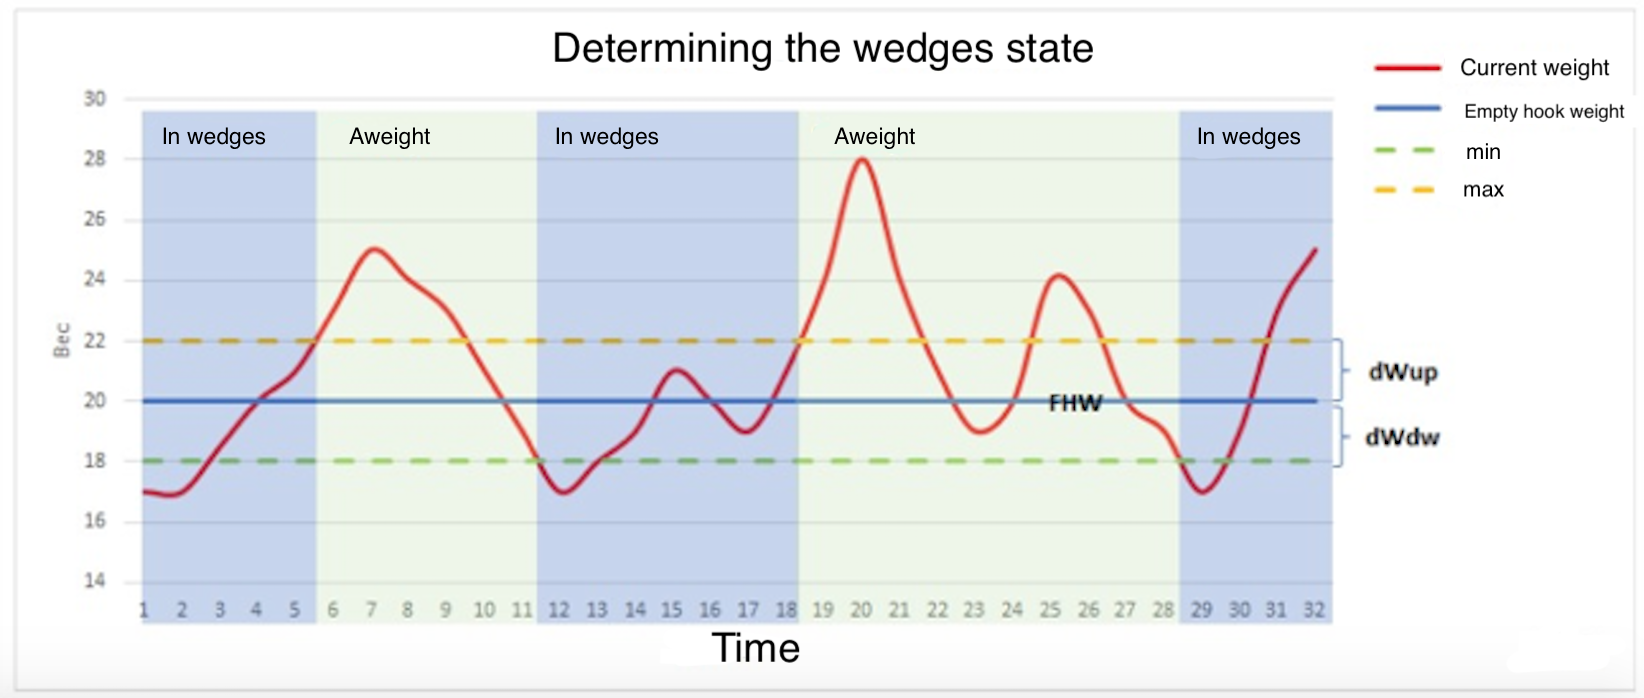

In [0]:
from IPython.display import Image
Image('desc.png')

**Task:**

It is a need to automatically determine the current state of the wedges position (“ON” or “OFF”).
The task is complicated by the fact that the “hook weight” parameter sometimes varies significantly due to various short-term (from seconds to minutes) dynamic effects, such as tool movement, tightening / landing of the drilling tool, vibration of the drilling rig and drilling tool, electromagnetic interference, recalibration of the sensor, as well as long-term (from hours to several days) effects such as temperature drift of the sensor or loosening of the sensor mount.

* SLIPS = ON, - in wedges
* SLIPS = OFF, - aweight

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import xgboost

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold

#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import datetime

In [0]:
data = pd.read_excel(r'Example_1.xlsx')
data['example'] = 1
data2 = pd.read_excel(r'Example_2.xlsx')
data2['example'] = 2
data3 = pd.read_excel(r'Example_3.xlsx')
data3['example'] = 3
data4 = pd.read_excel(r'Example_4.xlsx')
data4['example'] = 4
data5 = pd.read_excel(r'Example_5.xlsx')
data5['example'] = 5

data = pd.concat([data, data2, data3, data4, data5], sort = False)
data = data.rename(columns = {"Время": "date",
                              "Положение талевого блока, м": "block_position", 
                              "Вес на крюке, т": "weight",
                              "Нагрузка на долото, т": "rotor_load",
                              "Обороты ротора, об/мин": "rotor_turn",
                              "Мех. скорость, м/ч": "rotor_speed",
                              "Давление на входе, кгс/см²": "preasure",
                              
                              "Расход на входе, л/мин": "entry_spend",
                              "Глубина долота, м": "chisels_depth",
                              "Глубина скважины, м": "wells_depth",
                             
                              "Положение талевого блока, м.1": "block_position.1",
                              "Глубина скважины, м.1": "wells_depth.1",
                              "Глубина долота, м.1": "chisels_depth.1",       
                             })

In [0]:
data.head()

,date,block_position,weight,SLIPS,rotor_load,rotor_turn,rotor_speed,preasure,entry_spend,chisels_depth,wells_depth,block_position.1,wells_depth.1,chisels_depth.1,example
0,31 мая 12:15:00,30.01,27.75,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
1,31 мая 12:15:01,30.01,27.75,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
2,31 мая 12:15:02,30.01,26.06,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
3,31 мая 12:15:03,30.01,26.52,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
4,31 мая 12:15:04,30.01,26.52,ON,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1


In [0]:
def converter(datestring):
    res = datestring.split(' ')

    for old, new in [('янв', '01'), ('фев', '02'), ('мар', '03'), ('апр.', '04'), 
                     ('мая', '05'), ('июн', '06'), ('июл', '07'), ('авг', '08'), 
                     ('сен', '09'), ('окт', '10'), ('ноя', '11'), ('дек', '12')]:
        res[1] = res[1].replace(old, new)
    
    result = '2019' + "-" + res[1]  + "-" + res[0] + ' ' + res[2]
    return result

In [0]:
data['date'] = data['date'].apply(converter)
data["date"] = pd.to_datetime(data["date"])
data['SLIPS'] = data['SLIPS'].str.contains('ON').astype(bool)

**Task 1 [1 mark]**

Check:
* Data Types
* Shape of the dataset
* Null values - identify the columns to drop based on the % of missing values
* Distribution of values for each variable
* Check if some variables have identical values
* Drop redundant/useless data from the dataset


In [0]:
#YOUR CODE HERE

In [0]:
#Show data once again
data.head()

,date,block_position,weight,SLIPS,rotor_load,rotor_turn,rotor_speed,preasure,entry_spend,chisels_depth,wells_depth,block_position.1,wells_depth.1,chisels_depth.1,example
0,2019-05-31 12:15:00,30.01,27.75,True,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
1,2019-05-31 12:15:01,30.01,27.75,True,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
2,2019-05-31 12:15:02,30.01,26.06,True,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
3,2019-05-31 12:15:03,30.01,26.52,True,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1
4,2019-05-31 12:15:04,30.01,26.52,True,NaN,0.0,NaN,0.0,0.0,3076.74,3900.0,30.01,3900.0,3076.74,1


# Descriptive Statistics

Describe other examples, using a similar technique.

* Example 1 - Normal Data Quality
* Example 2 - Weight changes without transition wedges
* Example 3 - End of lift, empty weight and tool weight are very close
* Example 4 - Growth
* Example 5 - Wedges are aweight

In [0]:
data.set_index('date', inplace = True)
data[data['example'] == 1].plot(subplots = True, figsize = (15, 15))
plt.savefig('example1.png')
#data = data.reset_index()
#data = data.drop('index',axis=1)

In [0]:
# Calculate the correlation matrix
corr_matrix = data.corr(method = 'pearson').abs()
f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(corr_matrix, mask = np.zeros_like(corr_matrix, dtype = np.bool),
            square = True, ax = ax)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('The variables whose the correlations  > 0.9: {}'.format(to_drop) )

# Feature Engineering - optional for experiments

***1. Time-domain features***: mean, std, variance, skewness, root-mean square, kurtosis

***2. Frequence-domain features***: power bandwidth, mean frequency, paek frequency, peak values, peak frequency, harmonics

***3. Time-frequency-domain features***: spectral entropy, spectral kurtosis

# Building a model and tuning parameters

Because there we need to identify 2 classes (ON/OFF) we have a binary classification problem.

We will try to use Logistic Regression, Decision Trees, Random Forest, Naive Bayes, SVM and finally a voting ensemble that incorporates the best of these models.

In [0]:
y = data['SLIPS']
# We won't treat the data as time series, trying to inderstand using the set of parameters what is going on with the wedge
data.drop(['SLIPS',"example", "date"], axis = 1, inplace=True)

# Scaling Variables
---
Normalise trainind datasets into a scale between 0 and 1 before using them together.

In [0]:
def normalize(data):
    result = data.copy()
    for feature_name in data.columns:
        max_value = data[feature_name].max()
        min_value = data[feature_name].min()
        result[feature_name] = (data[feature_name] - min_value) / (max_value - min_value)
    return result

data = normalize(data)

**Task 2 [1 mark]**

Split the data into the training and testing datasets with the names:
* X_train - training data for variables
* X_test - testing data for variables
* y_train - training data for target variable
* y_test - testing data for target variable

As we have a Class Imbalance Problem, try stratified split, based on the target variable. 1/3 for testing dataset should be fine.


In [0]:
#YOUR CODE HERE

### Logistic regression

In [0]:
log = LogisticRegression()
#optimize a logistic regression function in scikit-learn by using a cross-validated grid parameter search
params = {'C':[0.01, 0.1, 1, 10]}

loggrid = RandomizedSearchCV(estimator = log, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
loggrid.fit(X_train,y_train)

In [0]:
lr_predictions = loggrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, lr_predictions)* 100.0))

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, lr_predictions)
print(confusion_matrix)

**Task 3 [1 mark]**

Please explain the results obtained in confusion matrix.


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_predictions))

In [0]:
lr_predictions_proba = loggrid.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, lr_predictions_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Logistic regression ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Task 4 [1 mark]**

Please explain the results shown in a ROC curve.


### Decision Trees

In [0]:
tc = DecisionTreeClassifier()
params = {'max_depth':[2,4,8]}

tcgrid = RandomizedSearchCV(estimator = tc, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
tcgrid.fit(X_train, y_train)

In [0]:
tc_predictions = tcgrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, tc_predictions)* 100.0))

**Task 5 [1 mark]**

Visualize and asses the results of the model.

### Random forest

In [0]:
rf = RandomForestClassifier()
params = {'max_depth': [8, 16, 32], 'min_samples_leaf':[2, 4, 8]}

rfgrid = RandomizedSearchCV(estimator = rf, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
rfgrid.fit(X_train, y_train)

In [0]:
rf_predictions = rfgrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, rf_predictions)* 100.0))

**Task 6 [1 mark]**

Visualize and asses the results of the model.

### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

In [0]:
nb_predictions = nb.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, nb_predictions)* 100.0))

**Task 7 [1 mark]**

Visualize and asses the results of the model.

### SVM classifier

In [0]:
from sklearn.svm import SVC
svc = SVC(C = 1, kernel = 'rbf', probability = True,  random_state = 0, class_weight = 'balanced')
svc.fit(X_train, y_train)

In [0]:
svc_predictions = svc.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, svc_predictions)* 100.0))

**Task 8 [1 mark]**

Visualize and asses the results of the model.

### Bagging Classifier

In [0]:
bag = BaggingClassifier(base_estimator = tcgrid.best_estimator_, n_estimators = 2)
#Change parameters, so the ensemble will consist of the best models
params = {'base_estimator':[LIST OF YOUR MODELS HERE],'n_estimators':[2, 3, 4]}

baggrid = RandomizedSearchCV(estimator = bag, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
baggrid.fit(X_train, y_train)

In [0]:
bg_predictions = baggrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, bg_predictions)* 100.0))

**Task 9 [1 mark]**

Visualize and asses the results of the model.

**Task 10 [1 mark]**

* [0.1] What else can be done in the pipeline?
* [0.1] Can we solve predictive maintenance task?
* [0.25] Which data is required to do this: Different data? More examples? Everything is present?
* [0.25] Can we classify the time series to understand the task done by workers on the rig? Another words, can we classify examples? 
* [0.3] Which data is required to do this: Different data? More examples? Everything is present?